In [1]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q coco_eval

  Preparing metadata (setup.py) ... done


In [4]:
!pip install pytorch-lightning



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 68.5 MB/s eta 0:00:00


In [5]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.0 MB/s eta 0:00:00


In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 53.0 MB/s eta 0:00:00


In [7]:
!ls drive/MyDrive/GRaZPEDWRI-DX/WristPreprocessed.zip

drive/MyDrive/GRaZPEDWRI-DX/WristPreprocessed.zip


In [8]:
!ls drive/MyDrive/FracAtlas.zip

drive/MyDrive/FracAtlas.zip


In [9]:
import torch
import transformers
import pytorch_lightning
import zipfile
import os
import shutil
import pandas as pd
import torch
from PIL import Image
import torchvision
import random
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.ops import box_convert, batched_nms
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

In [10]:
def extract_zip(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [11]:
dataset_path = '/content/drive/MyDrive/GRaZPEDWRI-DX/WristPreprocessed.zip'
extract_path = '/content/'
extract_zip(dataset_path,extract_path)



# **YOLOv11**

In [12]:
# Function to copy files based on CSV
def copy_files(split_name):
    csv_path = os.path.join(csv_folder, f"{split_name}.csv")
    if not os.path.exists(csv_path):
        print(f"CSV file {csv_path} not found!")
        return

    # Read the CSV file
    file_names = pd.read_csv(csv_path, header=None).iloc[1:, 0].tolist()
    print(file_names[0])
    # Copy images and labels
    for file_name in file_names:
        # Copy image
        src_image = os.path.join(image_folder, file_name)
        if not os.path.exists(src_image):
            src_image = os.path.join(image_folder, 'Non_fractured', file_name)

        dest_image = os.path.join(output_images, split_name, file_name)
        if os.path.exists(src_image):
            shutil.copy(src_image, dest_image)
        else:
            print(f"Image {src_image} not found!")

        # Copy label
        label_file = file_name.replace(".png", ".txt")
        src_label = os.path.join(label_folder, label_file)
        dest_label = os.path.join(output_labels, split_name, label_file)
        if os.path.exists(src_label):
            shutil.copy(src_label, dest_label)
        else:
            # If label is missing, create an empty file
            with open(dest_label, "w") as f:
                pass

# Paths to original folders and CSV files
image_folder = "/content/content/folder_structure/yolov5/images"  # Folder containing all images
label_folder = "/content/content/folder_structure/yolov5/labels"  # Folder containing all label files
csv_folder = "/content/Wristcsv"     # Folder containing train.csv, valid.csv

# Paths to the destination folders
output_base = "Wrist_YOLO"  # Output dataset folder
output_images = os.path.join(output_base, "images")
output_labels = os.path.join(output_base, "labels")

# Create train, val subfolders
splits = ["train", "val"]
for split in splits:
    os.makedirs(os.path.join(output_images, split), exist_ok=True)
    os.makedirs(os.path.join(output_labels, split), exist_ok=True)

# Process all splits
for split in splits:
    copy_files(split)

print("Dataset split and organized successfully!")

3249_1053216363_01_WRI-L1_F005.png
0019_0224740802_01_WRI-R2_M009.png
Dataset split and organized successfully!


In [13]:
import os

# Path to the directory you want to count files in
directory_path = "Wrist_YOLO/images/val"

# Count the number of files in the directory
file_count = 0
try:
    file_count = len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])
except FileNotFoundError:
    print(f"Directory '{directory_path}' not found.")

print(f"Number of files in '{directory_path}': {file_count}")

Number of files in 'Wrist_YOLO/images/val': 2710


In [14]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:00<00:00, 64.9MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(42)
train_results = model.train(
    data="Wrist_YOLO.yaml",  # path to dataset YAML
    epochs=60,  # number of training epochs
    imgsz=640,  # training image size
    device=device,  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)



engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=Wrist_YOLO.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=

100%|██████████| 755k/755k [00:00<00:00, 100MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 382MB/s]


AMP: checks passed ✅


train: Scanning /content/Wrist_YOLO/labels/train... 10840 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10840/10840 [00:53<00:00, 202.63it/s]


train: New cache created: /content/Wrist_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Wrist_YOLO/labels/val... 2710 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2710/2710 [00:13<00:00, 196.82it/s]


val: New cache created: /content/Wrist_YOLO/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.32G      1.726      2.071       1.46         24        640: 100%|██████████| 678/678 [01:26<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.21it/s]


                   all       2710       3614      0.832      0.682      0.802      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.32G      1.547      1.217      1.221         19        640: 100%|██████████| 678/678 [01:22<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.55it/s]

                   all       2710       3614      0.751      0.571      0.668      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.29G      1.568      1.244      1.247         20        640: 100%|██████████| 678/678 [01:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.71it/s]


                   all       2710       3614      0.853      0.708      0.816      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.28G      1.575      1.236      1.261         14        640: 100%|██████████| 678/678 [01:21<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.47it/s]


                   all       2710       3614      0.817      0.748      0.829       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.31G      1.544      1.159      1.245         20        640: 100%|██████████| 678/678 [01:20<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.52it/s]

                   all       2710       3614      0.858      0.727      0.842      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60       4.3G      1.509      1.113      1.239         22        640: 100%|██████████| 678/678 [01:20<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.46it/s]

                   all       2710       3614      0.835      0.753      0.846      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.31G       1.49      1.073      1.224         24        640: 100%|██████████| 678/678 [01:20<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.37it/s]

                   all       2710       3614      0.895      0.805      0.897      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.31G      1.475      1.037      1.217         19        640: 100%|██████████| 678/678 [01:20<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.58it/s]

                   all       2710       3614      0.905      0.818      0.911      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.31G      1.464      1.015      1.206         24        640: 100%|██████████| 678/678 [01:20<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.85it/s]

                   all       2710       3614      0.909      0.816      0.908       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.29G      1.444     0.9971      1.198         18        640: 100%|██████████| 678/678 [01:20<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.47it/s]

                   all       2710       3614      0.903      0.834      0.915      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.31G      1.438     0.9741      1.191         22        640: 100%|██████████| 678/678 [01:20<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.52it/s]

                   all       2710       3614      0.897      0.824      0.913      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60       4.3G      1.426     0.9653      1.191         21        640: 100%|██████████| 678/678 [01:20<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.75it/s]

                   all       2710       3614      0.898      0.827      0.914      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.32G       1.42     0.9501      1.183         17        640: 100%|██████████| 678/678 [01:20<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.19it/s]

                   all       2710       3614      0.918      0.838      0.922      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      4.29G      1.411     0.9275       1.17         17        640: 100%|██████████| 678/678 [01:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.64it/s]

                   all       2710       3614      0.926      0.835      0.927       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.31G      1.401     0.9126       1.17         21        640: 100%|██████████| 678/678 [01:23<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.68it/s]

                   all       2710       3614      0.915      0.854      0.929      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60       4.3G        1.4      0.906      1.174         16        640: 100%|██████████| 678/678 [01:21<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.51it/s]

                   all       2710       3614       0.92      0.843      0.924      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.31G      1.391     0.8948      1.162         19        640: 100%|██████████| 678/678 [01:21<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.87it/s]

                   all       2710       3614      0.917      0.858      0.935      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.29G       1.38     0.8903       1.16         16        640: 100%|██████████| 678/678 [01:21<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.42it/s]

                   all       2710       3614      0.917      0.845       0.93      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.31G      1.379     0.8772      1.159         17        640: 100%|██████████| 678/678 [01:20<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.46it/s]

                   all       2710       3614      0.914      0.858      0.935      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       4.3G      1.372     0.8678      1.156         26        640: 100%|██████████| 678/678 [01:21<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.96it/s]

                   all       2710       3614      0.923      0.861      0.941      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.31G      1.366     0.8538      1.151         24        640: 100%|██████████| 678/678 [01:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.58it/s]

                   all       2710       3614      0.924      0.857      0.937      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.29G      1.361     0.8451      1.153         20        640: 100%|██████████| 678/678 [01:21<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.58it/s]

                   all       2710       3614      0.923      0.861      0.937      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.31G       1.35     0.8398      1.146         14        640: 100%|██████████| 678/678 [01:21<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.71it/s]

                   all       2710       3614      0.917      0.862       0.94      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.29G       1.34     0.8382      1.136         27        640: 100%|██████████| 678/678 [01:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.24it/s]

                   all       2710       3614      0.928      0.864      0.944      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.32G      1.348     0.8307       1.14         13        640: 100%|██████████| 678/678 [01:20<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.39it/s]

                   all       2710       3614       0.93      0.874      0.947      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      4.29G      1.344     0.8221       1.14         23        640: 100%|██████████| 678/678 [01:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.39it/s]

                   all       2710       3614      0.932      0.869      0.948      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.31G       1.33     0.8031      1.132         17        640: 100%|██████████| 678/678 [01:21<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.60it/s]

                   all       2710       3614      0.929      0.881      0.948      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.29G      1.332     0.7978      1.128         16        640: 100%|██████████| 678/678 [01:21<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.81it/s]

                   all       2710       3614      0.933      0.871      0.946      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      4.33G      1.325     0.8018      1.131         19        640: 100%|██████████| 678/678 [01:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.68it/s]

                   all       2710       3614      0.924      0.874      0.943      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.29G      1.322     0.7871      1.125         11        640: 100%|██████████| 678/678 [01:19<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.62it/s]

                   all       2710       3614      0.928      0.883      0.949      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.31G      1.314     0.7854      1.126         18        640: 100%|██████████| 678/678 [01:20<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.85it/s]

                   all       2710       3614      0.935      0.881      0.952      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      4.31G      1.312     0.7754      1.117         20        640: 100%|██████████| 678/678 [01:21<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.77it/s]

                   all       2710       3614      0.933      0.881      0.951      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.32G      1.305     0.7574      1.114         11        640: 100%|██████████| 678/678 [01:20<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.51it/s]

                   all       2710       3614      0.929      0.881      0.949      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      4.29G      1.302     0.7643      1.118         20        640: 100%|██████████| 678/678 [01:20<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]

                   all       2710       3614      0.927       0.88      0.952      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.31G      1.293     0.7472      1.108         17        640: 100%|██████████| 678/678 [01:20<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.91it/s]

                   all       2710       3614      0.926      0.891      0.953      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.29G      1.293     0.7416      1.106         20        640: 100%|██████████| 678/678 [01:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.62it/s]

                   all       2710       3614      0.933       0.89      0.953      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      4.31G      1.275     0.7319      1.105         24        640: 100%|██████████| 678/678 [01:21<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.61it/s]

                   all       2710       3614      0.925        0.9      0.954      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      4.29G      1.282     0.7313      1.104         19        640: 100%|██████████| 678/678 [01:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.85it/s]

                   all       2710       3614      0.927        0.9      0.955      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.31G      1.269     0.7203      1.103         16        640: 100%|██████████| 678/678 [01:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.33it/s]

                   all       2710       3614      0.925      0.897      0.954       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.29G      1.269     0.7121      1.101         15        640: 100%|██████████| 678/678 [01:20<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.42it/s]

                   all       2710       3614      0.932      0.899      0.955      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.31G      1.262     0.7074      1.098         31        640: 100%|██████████| 678/678 [01:21<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.86it/s]

                   all       2710       3614      0.936      0.893      0.955       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      4.29G      1.254      0.698      1.095         22        640: 100%|██████████| 678/678 [01:20<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.55it/s]

                   all       2710       3614      0.937      0.893      0.954      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      4.32G      1.247     0.6962      1.088         17        640: 100%|██████████| 678/678 [01:20<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.67it/s]

                   all       2710       3614      0.933      0.901      0.957       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      4.29G      1.248     0.6873      1.085         21        640: 100%|██████████| 678/678 [01:21<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.93it/s]

                   all       2710       3614      0.935      0.898       0.96      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.31G      1.243     0.6824      1.086         23        640: 100%|██████████| 678/678 [01:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.38it/s]

                   all       2710       3614      0.942      0.898       0.96      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      4.31G       1.23     0.6756      1.082         25        640: 100%|██████████| 678/678 [01:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.49it/s]

                   all       2710       3614      0.936      0.897       0.96      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.31G      1.231     0.6679      1.081         18        640: 100%|██████████| 678/678 [01:21<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.74it/s]

                   all       2710       3614      0.939      0.898      0.958      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      4.29G      1.215     0.6552      1.076         18        640: 100%|██████████| 678/678 [01:21<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.64it/s]

                   all       2710       3614       0.94      0.897      0.958       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.31G      1.214     0.6543      1.075         27        640: 100%|██████████| 678/678 [01:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.67it/s]

                   all       2710       3614      0.942      0.897      0.959      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      4.29G      1.204     0.6472      1.072         24        640: 100%|██████████| 678/678 [01:21<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]

                   all       2710       3614       0.94      0.897      0.959      0.583


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.32G      1.192     0.5706      1.077         13        640: 100%|██████████| 678/678 [01:20<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.57it/s]

                   all       2710       3614      0.936      0.893      0.957      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.29G      1.177     0.5554      1.074          9        640: 100%|██████████| 678/678 [01:19<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.58it/s]

                   all       2710       3614      0.941      0.899      0.957      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.31G      1.164     0.5468      1.072         10        640: 100%|██████████| 678/678 [01:19<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.78it/s]

                   all       2710       3614      0.936      0.898      0.958      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      4.29G      1.151     0.5355      1.065         12        640: 100%|██████████| 678/678 [01:20<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.92it/s]

                   all       2710       3614      0.935      0.902       0.96      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.31G      1.143     0.5301      1.056         11        640: 100%|██████████| 678/678 [01:19<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.69it/s]

                   all       2710       3614      0.933        0.9      0.957       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.29G      1.131      0.521      1.054          9        640: 100%|██████████| 678/678 [01:19<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.61it/s]

                   all       2710       3614      0.936      0.896      0.957      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.31G      1.124     0.5116      1.051         11        640: 100%|██████████| 678/678 [01:19<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.66it/s]

                   all       2710       3614      0.941      0.893      0.957      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60       4.3G      1.113     0.5013      1.043         12        640: 100%|██████████| 678/678 [01:20<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.92it/s]

                   all       2710       3614      0.932      0.896      0.956      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      4.31G      1.104      0.498      1.041         12        640: 100%|██████████| 678/678 [01:20<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.61it/s]

                   all       2710       3614      0.937      0.896      0.957      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.29G      1.093     0.4919      1.037         10        640: 100%|██████████| 678/678 [01:20<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.59it/s]

                   all       2710       3614      0.939      0.899      0.957      0.577



60 epochs completed in 1.552 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.78it/s]


                   all       2710       3614      0.943      0.897       0.96      0.584
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# Evaluate model performance on the validation set
metrics = model.val()

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/Wrist_YOLO/labels/val.cache... 2710 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2710/2710 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 170/170 [00:15<00:00, 10.83it/s]


                   all       2710       3614      0.943      0.898      0.961      0.584
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
# Move the runswrist directory to Google Drive

import shutil

source_directory = 'runswrist'
destination_directory = '/content/drive/MyDrive/runswrist'

try:
    shutil.move(source_directory, destination_directory)
    print(f"Directory '{source_directory}' moved to '{destination_directory}' successfully.")
except FileNotFoundError:
    print(f"Source directory '{source_directory}' not found.")
except OSError as e:
    print(f"Error moving directory: {e}")

Directory 'runswrist' moved to '/content/drive/MyDrive/runswrist' successfully.



image 1/1 /content/Wrist_YOLO/images/val/0028_0578333865_02_WRI-R1_M008.png: 640x320 2 fractureds, 63.6ms
Speed: 1.9ms preprocess, 63.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


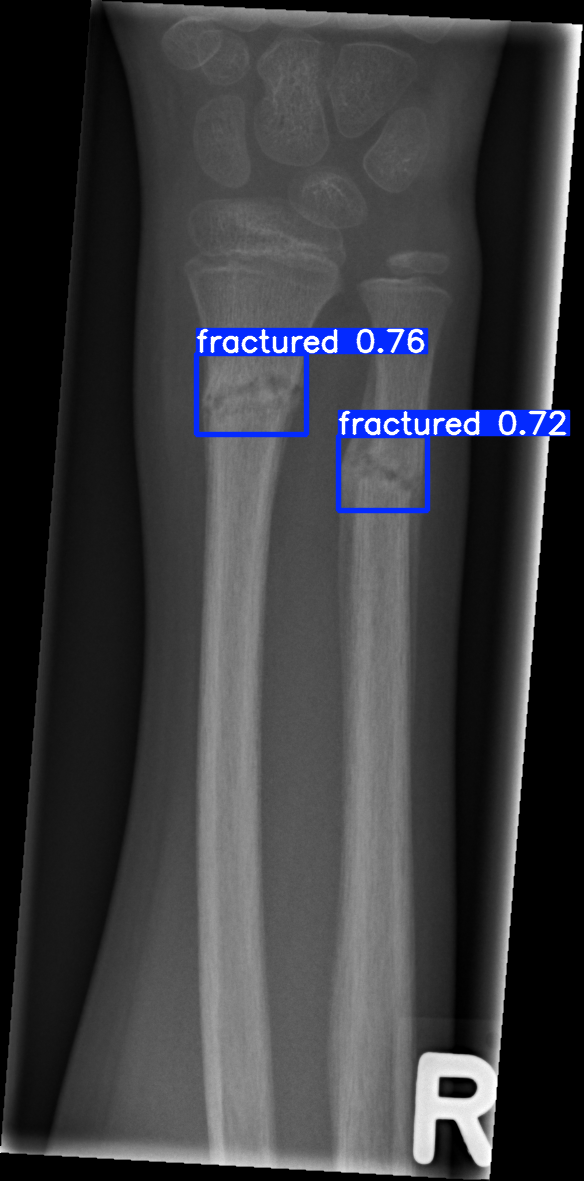

In [ ]:
results = model("/content/Wrist_YOLO/images/val/0028_0578333865_02_WRI-R1_M008.png")
results[0].show()

# Train again with pretrained backbone for binary classification on MURA


In [15]:
model2 = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:00<00:00, 231MB/s]


In [16]:
model2.model.model[:9].load_state_dict(torch.load('/content/drive/MyDrive/mura_backbone_weights_epoch11.pth'), strict = False)

<All keys matched successfully>

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(42)
train_results = model2.train(
    data="Wrist_YOLO.yaml",  # path to dataset YAML
    epochs=60,  # number of training epochs
    imgsz=640,  # training image size
    device=device,  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)


engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=Wrist_YOLO.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=

100%|██████████| 755k/755k [00:00<00:00, 27.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.9MB/s]


AMP: checks passed ✅


train: Scanning /content/Wrist_YOLO/labels/train... 10840 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10840/10840 [00:54<00:00, 198.61it/s]


train: New cache created: /content/Wrist_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Wrist_YOLO/labels/val... 2710 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2710/2710 [00:14<00:00, 190.52it/s]


val: New cache created: /content/Wrist_YOLO/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.33G      1.794       2.24      1.474         24        640: 100%|██████████| 678/678 [02:05<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:15<00:00,  5.47it/s]

                   all       2710       3614      0.803      0.638      0.759      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.33G      1.554      1.247      1.224         19        640: 100%|██████████| 678/678 [02:00<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.47it/s]


                   all       2710       3614      0.826      0.702      0.806      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60       4.3G      1.579      1.257      1.246         20        640: 100%|██████████| 678/678 [01:57<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.51it/s]


                   all       2710       3614      0.814      0.734      0.826      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60       4.3G      1.572      1.238      1.251         14        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.51it/s]

                   all       2710       3614      0.819      0.691      0.801       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.31G      1.545      1.158      1.246         20        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.46it/s]


                   all       2710       3614      0.875      0.779      0.878      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60       4.3G      1.513      1.116      1.237         22        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.60it/s]

                   all       2710       3614      0.894      0.762      0.871      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.32G       1.49      1.071      1.223         24        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.49it/s]

                   all       2710       3614      0.882      0.789      0.885      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.31G      1.471      1.039       1.21         19        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.52it/s]

                   all       2710       3614      0.895      0.801      0.895      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.32G       1.46      1.015      1.201         24        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.60it/s]

                   all       2710       3614        0.9      0.816      0.902      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60       4.3G      1.444     0.9942      1.197         18        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.55it/s]

                   all       2710       3614       0.91      0.813      0.909      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.31G      1.441     0.9797      1.189         22        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.40it/s]

                   all       2710       3614      0.907      0.816      0.913      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60       4.3G      1.427     0.9675      1.187         21        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.52it/s]

                   all       2710       3614      0.899      0.815      0.911       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.31G      1.425     0.9455      1.183         17        640: 100%|██████████| 678/678 [01:57<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.56it/s]

                   all       2710       3614      0.924      0.833      0.922      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       4.3G      1.413      0.929       1.17         17        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.43it/s]

                   all       2710       3614      0.893      0.826      0.907      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.32G      1.405     0.9257      1.174         21        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.43it/s]

                   all       2710       3614      0.913      0.842      0.923      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60       4.3G      1.404     0.9074      1.172         16        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.56it/s]

                   all       2710       3614      0.905      0.815      0.906      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.32G      1.393     0.9013      1.162         19        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.59it/s]

                   all       2710       3614      0.917       0.85      0.932      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       4.3G      1.386     0.8942       1.16         16        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.52it/s]

                   all       2710       3614       0.92      0.847      0.934      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.31G      1.383     0.8856      1.158         17        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.51it/s]

                   all       2710       3614      0.914      0.854       0.93      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       4.3G      1.374     0.8727      1.155         26        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.65it/s]

                   all       2710       3614      0.914      0.865      0.939      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.31G      1.367     0.8638      1.151         24        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.52it/s]

                   all       2710       3614      0.918      0.866       0.94      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.29G      1.364     0.8484      1.151         20        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.49it/s]

                   all       2710       3614      0.927      0.864      0.941      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.32G      1.347     0.8469      1.141         14        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.54it/s]

                   all       2710       3614       0.92      0.872      0.944       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.31G      1.342     0.8458      1.133         27        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.53it/s]

                   all       2710       3614      0.931      0.868      0.943       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.32G      1.353     0.8335      1.139         13        640: 100%|██████████| 678/678 [01:57<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.51it/s]

                   all       2710       3614      0.927      0.876      0.945      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60       4.3G      1.345     0.8274      1.131         23        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.58it/s]

                   all       2710       3614      0.921      0.879      0.946      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.31G      1.336     0.8117      1.129         17        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.71it/s]

                   all       2710       3614      0.923      0.877      0.947      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.31G      1.335     0.8018      1.129         16        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.61it/s]

                   all       2710       3614      0.927      0.877      0.944      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      4.31G      1.329     0.8048      1.126         19        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.55it/s]

                   all       2710       3614      0.928      0.884      0.949      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60       4.3G      1.327     0.7903      1.123         11        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.68it/s]

                   all       2710       3614      0.927      0.883      0.947      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.32G      1.321     0.7909      1.126         18        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.64it/s]

                   all       2710       3614      0.934      0.876      0.951      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      4.29G      1.316     0.7791      1.119         20        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.51it/s]

                   all       2710       3614      0.923      0.888      0.951      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.32G      1.305       0.77      1.116         11        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.64it/s]

                   all       2710       3614      0.931      0.882      0.948      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60       4.3G      1.305     0.7693      1.115         20        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.65it/s]

                   all       2710       3614       0.93      0.881      0.949      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.31G      1.295     0.7511      1.111         17        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.52it/s]

                   all       2710       3614      0.932      0.888      0.952      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       4.3G      1.295     0.7519      1.111         20        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.57it/s]

                   all       2710       3614      0.932      0.887      0.953      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      4.31G      1.283     0.7361      1.106         24        640: 100%|██████████| 678/678 [01:56<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.63it/s]

                   all       2710       3614      0.922      0.893      0.953      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60       4.3G      1.282     0.7398      1.104         19        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.51it/s]

                   all       2710       3614      0.932      0.886      0.951      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.31G      1.276     0.7284      1.098         16        640: 100%|██████████| 678/678 [01:57<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.42it/s]

                   all       2710       3614       0.93      0.893      0.955      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.31G      1.273     0.7174      1.097         15        640: 100%|██████████| 678/678 [01:58<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.53it/s]

                   all       2710       3614      0.935      0.892      0.954      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.31G      1.265     0.7142      1.096         31        640: 100%|██████████| 678/678 [01:58<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.44it/s]

                   all       2710       3614      0.936       0.89      0.953      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       4.3G      1.259     0.7047      1.093         22        640: 100%|██████████| 678/678 [01:58<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.49it/s]

                   all       2710       3614      0.927      0.893      0.953      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      4.31G      1.256     0.7084      1.095         17        640: 100%|██████████| 678/678 [01:58<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.42it/s]

                   all       2710       3614      0.931      0.898      0.955      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60       4.3G      1.255     0.6949       1.09         21        640: 100%|██████████| 678/678 [01:57<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.55it/s]

                   all       2710       3614      0.926        0.9      0.955      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.32G      1.252     0.6931      1.091         23        640: 100%|██████████| 678/678 [01:57<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.45it/s]

                   all       2710       3614      0.932      0.901      0.956      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       4.3G       1.24     0.6806      1.084         25        640: 100%|██████████| 678/678 [01:57<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.46it/s]

                   all       2710       3614      0.935      0.899      0.957      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.32G      1.239     0.6761      1.084         18        640: 100%|██████████| 678/678 [01:57<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.61it/s]

                   all       2710       3614      0.934      0.896      0.955       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60       4.3G      1.221     0.6654      1.078         18        640: 100%|██████████| 678/678 [01:57<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.58it/s]

                   all       2710       3614      0.934      0.902      0.956      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.32G      1.222     0.6633      1.077         27        640: 100%|██████████| 678/678 [01:57<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.48it/s]

                   all       2710       3614      0.935        0.9      0.956       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60       4.3G      1.211     0.6582      1.073         24        640: 100%|██████████| 678/678 [01:57<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.50it/s]

                   all       2710       3614       0.94      0.891      0.958      0.577


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.32G      1.198     0.5872      1.079         13        640: 100%|██████████| 678/678 [01:58<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.62it/s]

                   all       2710       3614      0.927      0.898      0.955      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.29G      1.187     0.5705      1.079          9        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.52it/s]

                   all       2710       3614      0.926      0.901      0.954      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.31G       1.17     0.5556       1.07         10        640: 100%|██████████| 678/678 [01:57<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.46it/s]

                   all       2710       3614       0.93      0.903      0.956      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      4.29G      1.162     0.5483      1.068         12        640: 100%|██████████| 678/678 [01:57<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.56it/s]

                   all       2710       3614      0.933      0.898      0.955      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.31G      1.151      0.541      1.064         11        640: 100%|██████████| 678/678 [01:57<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.52it/s]

                   all       2710       3614      0.943       0.89      0.955      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.31G      1.142     0.5323       1.06          9        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.53it/s]

                   all       2710       3614      0.929        0.9      0.953      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.32G      1.134      0.526      1.055         11        640: 100%|██████████| 678/678 [01:57<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.66it/s]

                   all       2710       3614      0.931      0.898      0.952      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60       4.3G      1.124     0.5205      1.047         12        640: 100%|██████████| 678/678 [01:57<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.58it/s]

                   all       2710       3614      0.924      0.903      0.952      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      4.32G      1.115     0.5137      1.046         12        640: 100%|██████████| 678/678 [01:56<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.55it/s]

                   all       2710       3614      0.924      0.904      0.952      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.29G      1.107     0.5077      1.044         10        640: 100%|██████████| 678/678 [01:57<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.65it/s]

                   all       2710       3614      0.925      0.901      0.952      0.573



60 epochs completed in 2.196 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.11it/s]


                   all       2710       3614      0.935      0.896      0.955       0.58
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


In [18]:
# Evaluate model performance on the validation set
metrics = model2.val()

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/Wrist_YOLO/labels/val.cache... 2710 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2710/2710 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 170/170 [00:18<00:00,  9.34it/s]


                   all       2710       3614      0.934      0.896      0.955       0.58
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2


In [19]:
# Move the runswrist directory to Google Drive

import shutil

source_directory = 'runswrist2'
destination_directory = '/content/drive/MyDrive/runswrist2'

try:
    shutil.move(source_directory, destination_directory)
    print(f"Directory '{source_directory}' moved to '{destination_directory}' successfully.")
except FileNotFoundError:
    print(f"Source directory '{source_directory}' not found.")
except OSError as e:
    print(f"Error moving directory: {e}")

Directory 'runswrist2' moved to '/content/drive/MyDrive/runswrist2' successfully.


# **Train again with pretrained backbone for both binary and class classification on MURA**

In [15]:
model3 = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:00<00:00, 298MB/s]


In [16]:
model3.model.model[:9].load_state_dict(torch.load('/content/drive/MyDrive/t2v2mura_backbone_weights_epoch14.pth'), strict = False)

<All keys matched successfully>

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(42)
train_results = model3.train(
    data="Wrist_YOLO.yaml",  # path to dataset YAML
    epochs=60,  # number of training epochs
    imgsz=640,  # training image size
    device=device,  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)


engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=Wrist_YOLO.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=

100%|██████████| 755k/755k [00:00<00:00, 125MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 339MB/s]


AMP: checks passed ✅


train: Scanning /content/Wrist_YOLO/labels/train... 10840 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10840/10840 [00:54<00:00, 198.24it/s]


train: New cache created: /content/Wrist_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Wrist_YOLO/labels/val... 2710 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2710/2710 [00:14<00:00, 187.27it/s]


val: New cache created: /content/Wrist_YOLO/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.32G      1.808      2.288      1.476         24        640: 100%|██████████| 678/678 [01:27<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.17it/s]

                   all       2710       3614      0.785      0.631      0.734      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.32G      1.556      1.235      1.221         19        640: 100%|██████████| 678/678 [01:25<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.24it/s]


                   all       2710       3614       0.82      0.696      0.801      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.29G      1.571       1.26      1.241         20        640: 100%|██████████| 678/678 [01:22<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.55it/s]


                   all       2710       3614       0.77      0.705      0.784       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.28G      1.575      1.243      1.257         14        640: 100%|██████████| 678/678 [01:22<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]

                   all       2710       3614      0.828      0.739      0.826       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.31G      1.543      1.171      1.249         20        640: 100%|██████████| 678/678 [01:21<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.27it/s]

                   all       2710       3614      0.848      0.717      0.833      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.29G      1.515      1.115      1.242         22        640: 100%|██████████| 678/678 [01:22<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.59it/s]

                   all       2710       3614      0.869      0.792      0.884      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.32G      1.495      1.079      1.223         24        640: 100%|██████████| 678/678 [01:22<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.75it/s]

                   all       2710       3614      0.868      0.786      0.883      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.31G      1.478      1.042      1.216         19        640: 100%|██████████| 678/678 [01:21<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]

                   all       2710       3614      0.888      0.782      0.885      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.31G      1.468      1.021      1.208         24        640: 100%|██████████| 678/678 [01:22<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.37it/s]

                   all       2710       3614      0.894      0.814      0.905      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.29G       1.45     0.9922      1.205         18        640: 100%|██████████| 678/678 [01:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.51it/s]

                   all       2710       3614      0.886      0.795       0.89      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.31G      1.447     0.9877      1.199         22        640: 100%|██████████| 678/678 [01:22<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.67it/s]

                   all       2710       3614      0.916      0.815      0.911      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.29G       1.43     0.9749      1.195         21        640: 100%|██████████| 678/678 [01:21<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.59it/s]

                   all       2710       3614      0.849      0.709      0.804      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.32G      1.425     0.9578      1.182         17        640: 100%|██████████| 678/678 [01:21<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.48it/s]

                   all       2710       3614       0.91      0.849      0.922      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      4.29G      1.416      0.936       1.18         17        640: 100%|██████████| 678/678 [01:21<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  7.08it/s]

                   all       2710       3614      0.896      0.772      0.888      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.31G      1.405     0.9311       1.18         21        640: 100%|██████████| 678/678 [01:21<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.57it/s]

                   all       2710       3614      0.914      0.836      0.924      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60       4.3G      1.404     0.9134      1.178         16        640: 100%|██████████| 678/678 [01:22<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.51it/s]

                   all       2710       3614      0.916      0.851      0.929      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.31G      1.391     0.9074      1.172         19        640: 100%|██████████| 678/678 [01:21<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.30it/s]

                   all       2710       3614       0.92      0.861      0.934      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.29G      1.385     0.8985      1.164         16        640: 100%|██████████| 678/678 [01:22<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.27it/s]

                   all       2710       3614      0.914      0.846      0.931      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.31G      1.388     0.8824      1.162         17        640: 100%|██████████| 678/678 [01:22<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.76it/s]

                   all       2710       3614       0.92      0.854      0.931      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      4.29G      1.377     0.8759      1.159         26        640: 100%|██████████| 678/678 [01:23<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.59it/s]

                   all       2710       3614      0.929      0.858      0.938      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.31G      1.371     0.8651      1.154         24        640: 100%|██████████| 678/678 [01:22<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.37it/s]

                   all       2710       3614       0.92      0.863      0.939      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.29G      1.368     0.8519      1.155         20        640: 100%|██████████| 678/678 [01:23<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.58it/s]

                   all       2710       3614      0.924      0.865      0.939      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.31G      1.352     0.8521      1.148         14        640: 100%|██████████| 678/678 [01:22<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.48it/s]

                   all       2710       3614      0.915      0.874      0.938      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.29G      1.348      0.842      1.135         27        640: 100%|██████████| 678/678 [01:22<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.33it/s]

                   all       2710       3614      0.932      0.872      0.943      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.31G      1.353     0.8438       1.15         13        640: 100%|██████████| 678/678 [01:22<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.13it/s]

                   all       2710       3614      0.922      0.876      0.945      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      4.29G      1.344     0.8282      1.138         23        640: 100%|██████████| 678/678 [01:22<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.62it/s]

                   all       2710       3614      0.919       0.87      0.941      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.31G      1.333     0.8221      1.138         17        640: 100%|██████████| 678/678 [01:23<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.33it/s]

                   all       2710       3614      0.922      0.853      0.935      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.29G      1.339     0.8094      1.134         16        640: 100%|██████████| 678/678 [01:22<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.32it/s]

                   all       2710       3614      0.931      0.878      0.946      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      4.33G      1.333     0.8109      1.135         19        640: 100%|██████████| 678/678 [01:23<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.69it/s]

                   all       2710       3614      0.922       0.88      0.946      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.29G       1.33     0.7971      1.129         11        640: 100%|██████████| 678/678 [01:23<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.55it/s]

                   all       2710       3614       0.92      0.886      0.948      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.31G      1.321     0.8015      1.129         18        640: 100%|██████████| 678/678 [01:23<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.37it/s]

                   all       2710       3614      0.922      0.884      0.947      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60       4.3G      1.315     0.7864      1.124         20        640: 100%|██████████| 678/678 [01:22<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.66it/s]

                   all       2710       3614      0.922      0.888      0.948      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.32G      1.312       0.78      1.123         11        640: 100%|██████████| 678/678 [01:23<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.72it/s]

                   all       2710       3614      0.929      0.884      0.951      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      4.29G       1.31     0.7762      1.127         20        640: 100%|██████████| 678/678 [01:23<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.39it/s]

                   all       2710       3614       0.92      0.892       0.95       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.31G      1.299     0.7592      1.114         17        640: 100%|██████████| 678/678 [01:23<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.37it/s]

                   all       2710       3614      0.936      0.882       0.95      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.29G      1.302     0.7565      1.116         20        640: 100%|██████████| 678/678 [01:22<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]

                   all       2710       3614      0.938      0.887      0.954      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      4.31G      1.284     0.7444       1.11         24        640: 100%|██████████| 678/678 [01:23<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.15it/s]

                   all       2710       3614      0.926      0.888       0.95      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      4.29G      1.287     0.7495      1.112         19        640: 100%|██████████| 678/678 [01:23<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.18it/s]

                   all       2710       3614      0.937      0.888      0.953      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.31G      1.277     0.7364      1.107         16        640: 100%|██████████| 678/678 [01:24<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.66it/s]

                   all       2710       3614      0.925       0.89      0.951      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.29G      1.278     0.7235      1.102         15        640: 100%|██████████| 678/678 [01:23<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.40it/s]

                   all       2710       3614      0.926      0.896      0.953      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.31G      1.271     0.7174      1.103         31        640: 100%|██████████| 678/678 [01:23<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.62it/s]

                   all       2710       3614      0.926      0.894      0.952      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       4.3G      1.266     0.7099      1.105         22        640: 100%|██████████| 678/678 [01:23<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.64it/s]

                   all       2710       3614       0.93      0.894      0.953      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60       4.3G       1.26     0.7176      1.099         17        640: 100%|██████████| 678/678 [01:24<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.44it/s]

                   all       2710       3614      0.929      0.894      0.952      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      4.31G      1.257     0.7026      1.094         21        640: 100%|██████████| 678/678 [01:26<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  7.04it/s]

                   all       2710       3614      0.925      0.899      0.954       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.32G      1.253     0.7047      1.095         23        640: 100%|██████████| 678/678 [01:23<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.29it/s]

                   all       2710       3614      0.933      0.892      0.953      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      4.29G      1.243     0.6921      1.091         25        640: 100%|██████████| 678/678 [01:22<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.16it/s]

                   all       2710       3614      0.928      0.896      0.955      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.32G      1.242     0.6867      1.089         18        640: 100%|██████████| 678/678 [01:22<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.78it/s]

                   all       2710       3614      0.934      0.896      0.957      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60       4.3G      1.228     0.6736      1.087         18        640: 100%|██████████| 678/678 [01:24<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.54it/s]

                   all       2710       3614      0.928      0.901      0.956      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.31G      1.225     0.6681      1.086         27        640: 100%|██████████| 678/678 [01:24<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.76it/s]

                   all       2710       3614      0.933      0.896      0.956       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      4.29G      1.218     0.6664      1.084         24        640: 100%|██████████| 678/678 [01:25<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.36it/s]

                   all       2710       3614      0.932      0.897      0.953      0.578


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.32G      1.206     0.5933      1.091         13        640: 100%|██████████| 678/678 [01:21<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]

                   all       2710       3614      0.922      0.906      0.953      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.29G      1.194     0.5769      1.087          9        640: 100%|██████████| 678/678 [01:21<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.56it/s]

                   all       2710       3614      0.923      0.911      0.954       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.32G      1.178     0.5634      1.081         10        640: 100%|██████████| 678/678 [01:21<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:10<00:00,  7.75it/s]

                   all       2710       3614       0.93      0.904      0.954      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      4.29G      1.167     0.5548      1.077         12        640: 100%|██████████| 678/678 [01:21<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.62it/s]

                   all       2710       3614      0.931      0.899      0.954      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.31G       1.16     0.5498      1.071         11        640: 100%|██████████| 678/678 [01:20<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.50it/s]

                   all       2710       3614       0.93      0.901      0.955      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.29G      1.151     0.5409      1.067          9        640: 100%|██████████| 678/678 [01:20<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.15it/s]

                   all       2710       3614       0.93      0.897      0.952      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.31G      1.142     0.5319      1.061         11        640: 100%|██████████| 678/678 [01:21<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.63it/s]

                   all       2710       3614      0.921      0.907      0.953      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      4.29G      1.135     0.5276      1.055         12        640: 100%|██████████| 678/678 [01:21<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.94it/s]

                   all       2710       3614      0.928      0.902      0.954      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      4.32G      1.128     0.5218      1.056         12        640: 100%|██████████| 678/678 [01:21<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.23it/s]

                   all       2710       3614      0.925      0.904      0.953      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.29G      1.119     0.5131      1.052         10        640: 100%|██████████| 678/678 [01:20<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:11<00:00,  7.20it/s]

                   all       2710       3614      0.924      0.906      0.953      0.574



60 epochs completed in 1.588 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:12<00:00,  6.64it/s]


                   all       2710       3614      0.928      0.895      0.955      0.581
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# Evaluate model performance on the validation set
metrics = model3.val()

In [ ]:
# Move the runswrist directory to Google Drive

import shutil

source_directory = 'runswrist3'
destination_directory = '/content/drive/MyDrive/runswrist3'

try:
    shutil.move(source_directory, destination_directory)
    print(f"Directory '{source_directory}' moved to '{destination_directory}' successfully.")
except FileNotFoundError:
    print(f"Source directory '{source_directory}' not found.")
except OSError as e:
    print(f"Error moving directory: {e}")